# Imports

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import statistics

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, Input, Lambda
import tensorflow as tf

#np.set_printoptions(threshold=np.inf)

# Connecto to Google Drive

Connecting to my own google drive to abe able to save a checkpoint for my models below.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_models_reddit_sentiment"

Mounted at /content/drive


# Retriving the data

Here we are retriving the data from my repository located in the github so that we can have the .csv file with all the necessary data for our models.

In [3]:
# Retrieving the data
!wget "https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_prediction%20(reddit%20posts)/final_data_reddit_bitcoin.csv"

--2023-06-14 20:30:08--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_prediction%20(reddit%20posts)/final_data_reddit_bitcoin.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870950 (851K) [text/plain]
Saving to: ‘final_data_reddit_bitcoin.csv’

final_data_reddit_b 100%[===================>] 850.54K  --.-KB/s    in 0.05s   

2023-06-14 20:30:08 (18.4 MB/s) - ‘final_data_reddit_bitcoin.csv’ saved [870950/870950]



In [4]:
# Load in the merged and final data
org_df = pd.read_csv('/content/final_data_reddit_bitcoin.csv',index_col=0)

In [5]:
# Here we can present the number of rows so that we can see that there are 4679
# entries
len(org_df)

4679

## Information about the data

In this dataset, there are 4679 rows corresponding to the number of days of gathered bitcoin data. The dataset consists of 13 columns (features) in total. Apart from the reddit data, there is also bitcoin data available. The reddit data provides information about:
* reddit_flair: The label or tag assigned to a post or comment on Reddit.
* reddit_tb_polarity: Sentiment polarity (positive, negative, or neutral) of a post or comment.
* reddit_tb_subjectivity: Subjectivity level (objective to subjective) of a post or comment.
* reddit_sid_pos: Count or score of positive sentiment words or phrases.
* reddit_sid_neg: Count or score of negative sentiment words or phrases.
* reddit_sid_neu: Count or score of neutral sentiment words or phrases.
* reddit_sid_com: Count or score of common words or phrases.

The bitcoin columns they are self explanatory about what they are expect for:

* Volume: How many coins have been sold in that amount of time (in our case is 1 day)
* Market: The total value of all circulating coins in the market

The data starts from `2010-07-17` until `2023-05-16`. I couldn't procure more data because 3 days later (2023-05-19) the reddit API was closed and couldn't get anymore entries.



In [6]:
org_df.head(10)

,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,Open,High,Low,Close,Volume,Market Cap
date,,,,,,,,,,,,,
2010-07-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0858,0.0858,0.0858,0.0858,0.0,0.0
2010-07-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0808,0.0808,0.0808,0.0808,0.0,0.0
2010-07-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0747,0.0747,0.0747,0.0747,0.0,0.0
2010-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0792,0.0792,0.0792,0.0792,0.0,0.0
2010-07-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0505,0.0505,0.0505,0.0505,0.0,0.0
2010-07-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0626,0.0626,0.0626,0.0626,0.0,0.0
2010-07-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0545,0.0545,0.0545,0.0545,0.0,0.0
2010-07-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0505,0.0505,0.0505,0.0505,0.0,0.0
2010-07-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0560,0.0560,0.0560,0.0560,0.0,0.0


In [7]:
org_df.tail(10)

,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,Open,High,Low,Close,Volume,Market Cap
date,,,,,,,,,,,,,
2023-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28417.98,28618.11,27302.45,27692.99,3.361429e+10,5.405927e+11
2023-05-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27667.26,27793.76,27376.73,27636.66,3.496925e+10,5.344236e+11
2023-05-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27629.96,28286.57,26961.57,27624.54,3.470029e+10,5.369229e+11
2023-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27598.80,27598.80,26768.01,27002.28,4.466839e+10,5.281794e+11
2023-05-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26968.60,27040.19,25954.76,26791.96,4.374442e+10,5.130654e+11
2023-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26795.03,27001.34,26705.35,26789.06,4.064762e+10,5.193336e+11
2023-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26785.60,27136.65,26676.47,26906.17,2.963904e+10,5.202518e+11
2023-05-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26917.59,27613.40,26754.32,27192.17,3.734884e+10,5.293194e+11
2023-05-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27158.66,27289.16,26891.41,27025.77,4.049790e+10,5.243667e+11


In [8]:
org_df.columns

Index(['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity',
       'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com',
       'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'],
      dtype='object')

# Creating the dataset

In this chapter here we're going to create out datasets in order to have our data ready for our models.



We need to convert the data into a different "data type" so that we can convert this data into training and testing data sets. Converting the data into `float32` is a necessary modification so that the model can be fed with optimal data for efficiency and peformance. As well so that we wouldn't have any "shape errors" when training the model. Also some normalization took place where all the numeric data from the "dataset" was transformed between the 0 and 1.

We perform preprocessing on the data before feeding it to our model for several reasons. One reason is to ensure consistency in the format and structure of the data across all columns, making it easier to manipulate and interpret. Additionally, machine learning models often benefit from having data scaled between 0 and 1, as it facilitates their learning process.

In [9]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 13


## Creating the hyperparameters

We're creating here the parameters (some of them atleast) is that we need them in order to create our train and test dataset.

* `LOOK_BACK`: Represents the number of days that the model will look back to analyze the data in order to predict the next price of bitcoin.
* `EPOCHS`: I've chosed 1000 because of the EarlyStopping callback that will interrupt the fitting of the model after the validation loss stagnates for 50 epochs.
* `BATCH_SIZE`: Since we have a small dataset and the model isn't that complex to begin with, we can give 128 of batches to feed the model's training.
* `HORIZON`: Is equal to one because in my research I wanted to predict the exact price of bitcoin.

In [10]:
# Hyperparameters
LOOK_BACK = 30
EPOCHS = 1000
BATCH_SIZE = 128
HORIZON = 1

## Creating the test and train dataset

This code prepares time series data for training and testing a prediction model. It splits the dataset into training and testing sets based on a specified percentage (in our case is 80% training and 20% testing). The create_dataset function creates input-output pairs using a sliding window approach. The input data is reshaped to match the expected format for a recurrent neural network model. The code then prints the lengths of the training and testing datasets, as well as the value of LOOK_BACK.

In [11]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  print(len(dataset)-look_back-1)
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=LOOK_BACK)
testX, testY = create_dataset(test, pred_col, look_back=LOOK_BACK)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], LOOK_BACK, num_of_features))
testX = np.reshape(testX, (testX.shape[0],LOOK_BACK, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('LOOK_BACK ', LOOK_BACK)

3712
905
Training dataset length  3743
Testing dataset length  936
LOOK_BACK  30


In [12]:
# Create a function to implement a ModelCheckoint callback with a specific filename
# We need this method to load the best model so that we can see the performance
def create_model_checkpoint(model_name, save_path = GOOGLE_DRIVE_PATH):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath = os.path.join(save_path, model_name),
      verbosity = 0, # only output a limited amount of text
      save_best_only = True
  )

# Creating the models

In this chapter here we're going to create the models that we're going to test them against our data.

What is common for all of the models are the callbacks:

* EarlyStopping to stop the model from fitting when it seems it can't learn anymore. I've chosen 200 epochs since for the previous models it seemded to work just fine and it applied here as well
* ReduceLROnPlateau is set to `val_loss` to slow down the learning rate if the model is learning to fast to slow it down and have a better adjustment for the weights and everything. This is also set for 50 epochs since it proved to be the most efficient
* *ModelCheckpoint is to save the best model based on the `val_loss` and is used just for the CNN and RNN models since the Embedding model is build using multiple ones and I didn't find a way to save all of them as a whole.

## Model 1: LSTM

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is well-suited for processing and analyzing time series data. It looks at the previous data and tries to remember and forget selectively what's important and necessary for it from the past. This makes them effective in modeling and predicting sequences of data. It can identify trends, seasonality, and other factors that affect Bitcoin price movements using a combination of short-term and long-term factors.

Since we're talking predicting the price of bitcoin using multivariate data where we're combining the prices of the coin with the reddit posts about it we're creating a model that uses sentiment analysis to predict the next price.

Below we can see the model isn't a complex one, we have just one layer of LSTM of input shape of the number of days we want to look back in the past and number of features.

The models is made of:

*   One LSTM layer with 128 units
*   One output layer consisted of 1 Dense layer with 1 neuron (HORIZON which represents the number of days we want to predict) with "linear" activation because we just want the raw value getting out of the model
* We use MSE (mean squared error) as it is common in Time Series Data predictions since we are trying to predict some number and we want to see how off (in our case we want to see how many dollars are we off) from the original value
* And "Adam" optimizer since it's one of the most popular ones and has the best capabilities for this kind of problems. From many tests it proved to be the best suited



In [13]:
# LSTM Hyperparameters
LSTM_LAYERS = 128

# Create and fit the LSTM network
model_lstm = Sequential(name="bitcoin_prediction_reddit_sentiment_lstm")
model_lstm.add(LSTM(LSTM_LAYERS, input_shape=(LOOK_BACK, num_of_features), name="lstm_layer"))
model_lstm.add(Dense(HORIZON, activation="linear", name="output_layer"))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
history_lstm = model_lstm.fit(
    trainX,
    trainY,
    validation_split=0.30,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            patience=50
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=100,
            restore_best_weights=True
        ),
        create_model_checkpoint(model_name=model_lstm.name)
    ]
)

Epoch 1/1000
15/21 [====================>.........] - ETA: 0s - loss: 0.0037

21/21 [==============================] - 15s 352ms/step - loss: 0.0030 - val_loss: 0.0134 - lr: 0.0010
Epoch 2/1000
17/21 [=======================>......] - ETA: 0s - loss: 7.7657e-04

21/21 [==============================] - 5s 224ms/step - loss: 7.7877e-04 - val_loss: 0.0085 - lr: 0.0010
Epoch 3/1000
17/21 [=======================>......] - ETA: 0s - loss: 5.7935e-04

21/21 [==============================] - 5s 258ms/step - loss: 5.2549e-04 - val_loss: 0.0024 - lr: 0.0010
Epoch 4/1000
15/21 [====================>.........] - ETA: 0s - loss: 1.2479e-04

21/21 [==============================] - 5s 236ms/step - loss: 1.2519e-04 - val_loss: 7.9281e-04 - lr: 0.0010
Epoch 5/1000
16/21 [=====================>........] - ETA: 0s - loss: 7.8122e-05

21/21 [==============================] - 4s 208ms/step - loss: 8.7657e-05 - val_loss: 5.2694e-04 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 0s 10ms/step - loss: 5.0876e-05 - val_loss: 5.3044e-04 - lr: 0.0010
Epoch 7/1000
15/21 [====================>.........] - ETA: 0s - loss: 5.1383e-05

21/21 [==============================] - 5s 266ms/step - loss: 6.1358e-05 - val_loss: 3.9566e-04 - lr: 0.0010
Epoch 8/1000
17/21 [=======================>......] - ETA: 0s - loss: 4.6999e-05

21/21 [==============================] - 5s 230ms/step - loss: 4.4654e-05 - val_loss: 2.4956e-04 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - 0s 11ms/step - loss: 9.6818e-05 - val_loss: 2.8484e-04 - lr: 0.0010
Epoch 10/1000
16/21 [=====================>........] - ETA: 0s - loss: 1.0983e-04

21/21 [==============================] - 4s 206ms/step - loss: 9.2400e-05 - val_loss: 2.1626e-04 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - 0s 11ms/step - loss: 3.4565e-04 - val_loss: 4.2756e-04 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 0s 11ms/step - loss: 4.1613e-04 - val_loss: 2.3392e-04 - lr: 0.0010
Epoch 13/1000
16/21 [=====================>........] - ETA: 0s - loss: 5.7425e-04

21/21 [==============================] - 6s 276ms/step - loss: 4.7988e-04 - val_loss: 1.8458e-04 - lr: 0.0010
Epoch 14/1000
21/21 [==============================] - 0s 11ms/step - loss: 2.0470e-04 - val_loss: 2.8386e-04 - lr: 0.0010
Epoch 15/1000
17/21 [=======================>......] - ETA: 0s - loss: 4.1938e-05

21/21 [==============================] - 4s 207ms/step - loss: 3.7299e-05 - val_loss: 1.8240e-04 - lr: 0.0010
Epoch 16/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.8419e-05 - val_loss: 1.8577e-04 - lr: 0.0010
Epoch 17/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.6542e-05 - val_loss: 1.9011e-04 - lr: 0.0010
Epoch 18/1000
21/21 [==============================] - 0s 11ms/step - loss: 2.0876e-05 - val_loss: 1.8851e-04 - lr: 0.0010
Epoch 19/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.6530e-05 - val_loss: 1.8787e-04 - lr: 0.0010
Epoch 20/1000
21/21 [==============================] - 0s 11ms/step - loss: 1.0375e-05 - val_loss: 1.9095e-04 - lr: 0.0010
Epoch 21/1000
21/21 [==============================] - 0s 10ms/step - loss: 7.9641e-06 - val_loss: 1.9943e-04 - lr: 0.0010
Epoch 22/1000
21/21 [==============================] - 0s 11ms/step - loss: 7.7582e-06 - val_loss: 2.0748e-04 - lr: 0.0010
Epoch 23/1000
21/21 [==========

21/21 [==============================] - 5s 243ms/step - loss: 2.0839e-04 - val_loss: 1.7489e-04 - lr: 0.0010
Epoch 46/1000
21/21 [==============================] - 0s 9ms/step - loss: 9.4025e-05 - val_loss: 3.1719e-04 - lr: 0.0010
Epoch 47/1000
21/21 [==============================] - 0s 11ms/step - loss: 9.9620e-05 - val_loss: 2.4927e-04 - lr: 0.0010
Epoch 48/1000
21/21 [==============================] - 0s 9ms/step - loss: 5.7241e-05 - val_loss: 2.1361e-04 - lr: 0.0010
Epoch 49/1000
21/21 [==============================] - 0s 11ms/step - loss: 7.8451e-05 - val_loss: 2.8587e-04 - lr: 0.0010
Epoch 50/1000
19/21 [==========================>...] - ETA: 0s - loss: 6.2995e-05

21/21 [==============================] - 4s 201ms/step - loss: 5.9667e-05 - val_loss: 1.6875e-04 - lr: 0.0010
Epoch 51/1000
18/21 [========================>.....] - ETA: 0s - loss: 2.7598e-05

21/21 [==============================] - 6s 279ms/step - loss: 3.0016e-05 - val_loss: 1.6582e-04 - lr: 0.0010
Epoch 52/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.9313e-05 - val_loss: 1.9609e-04 - lr: 0.0010
Epoch 53/1000
21/21 [==============================] - 0s 10ms/step - loss: 2.9917e-05 - val_loss: 2.4105e-04 - lr: 0.0010
Epoch 54/1000
21/21 [==============================] - 0s 9ms/step - loss: 2.9546e-05 - val_loss: 1.7937e-04 - lr: 0.0010
Epoch 55/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.9647e-05 - val_loss: 1.6965e-04 - lr: 0.0010
Epoch 56/1000
21/21 [==============================] - 0s 11ms/step - loss: 1.7244e-05 - val_loss: 2.1775e-04 - lr: 0.0010
Epoch 57/1000
21/21 [==============================] - 0s 9ms/step - loss: 2.2159e-05 - val_loss: 2.5317e-04 - lr: 0.0010
Epoch 58/1000
21/21 [==============================] - 0s 10ms/step - loss: 2.6826e-05 - val_loss: 2.2397e-04 - lr: 0.0010
Epoch 59/1000
21/21 [===========

21/21 [==============================] - 4s 203ms/step - loss: 3.9614e-05 - val_loss: 1.6566e-04 - lr: 1.0000e-04
Epoch 62/1000
17/21 [=======================>......] - ETA: 0s - loss: 3.7477e-05

21/21 [==============================] - 4s 224ms/step - loss: 3.7390e-05 - val_loss: 1.6364e-04 - lr: 1.0000e-04
Epoch 63/1000
20/21 [===========================>..] - ETA: 0s - loss: 2.8161e-05

21/21 [==============================] - 5s 266ms/step - loss: 2.8197e-05 - val_loss: 1.6120e-04 - lr: 1.0000e-04
Epoch 64/1000
21/21 [==============================] - 0s 10ms/step - loss: 2.4269e-05 - val_loss: 1.6299e-04 - lr: 1.0000e-04
Epoch 65/1000
21/21 [==============================] - 0s 9ms/step - loss: 2.0068e-05 - val_loss: 1.6758e-04 - lr: 1.0000e-04
Epoch 66/1000
21/21 [==============================] - 0s 12ms/step - loss: 1.7132e-05 - val_loss: 1.7458e-04 - lr: 1.0000e-04
Epoch 67/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.4607e-05 - val_loss: 1.8368e-04 - lr: 1.0000e-04
Epoch 68/1000
21/21 [==============================] - 0s 9ms/step - loss: 1.2596e-05 - val_loss: 1.9431e-04 - lr: 1.0000e-04
Epoch 69/1000
21/21 [==============================] - 0s 10ms/step - loss: 1.0928e-05 - val_loss: 2.0611e-04 - lr: 1.0000e-04
Epoch 70/1000
21/21 [==============================] - 0s 10ms/step - loss: 9.5581e-06 - val_loss: 2.1868e-04 - lr: 1.0000e-04


In [14]:
# Loading it the best model saved
model_lstm = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/bitcoin_prediction_reddit_sentiment_lstm")

## Model 2: CNN

This model was done to show the differences in performance is between the RNN and the CNN models. In the results section there is a clear difference between which model handles better the given data.

Convolutional neural networks (CNNs) offer unique advantages when applied to time series data analysis, particularly in the context of multivariate Bitcoin data enriched with sentiment analysis from Reddit posts.

CNNs excel at capturing local patterns and dependencies within data. When dealing with time series data, CNNs can identify temporal patterns by applying convolutional filters to localized regions of the input. Also, they have the ability to automatically learn meaningful features directly from the data, eliminating the need for manual feature engineering.

The models is made of:

*   One Conv1D layer with 128 units, `kernel_size` of 8, `padding=same` and `strides=1`
*   One simple LSTM layer with 128 units
*   One output layer consisted of 1 Dense layer with 1 neuron (HORIZON which represents the number of days we want to predict) with "linear" activation because we just want the raw value getting out of the model
* We use MSE (mean squared error) as it is common in Time Series Data predictions since we are trying to predict some number and we want to see how off (in our case we want to see how many dollars are we off) from the original value
* And "Adam" optimizer since it's one of the most popular ones and has the best capabilities for this kind of problems. From many tests it proved to be the best suited

In [15]:
# CNN Hyperparameters
CNN_LAYERS = 128
CNN_KERNEL_SIZE = 8

# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_cnn = tf.keras.Sequential([
    Conv1D(filters=CNN_LAYERS, kernel_size=CNN_KERNEL_SIZE, padding="same", strides=1, input_shape=(LOOK_BACK, num_of_features), name="cond1d_layer"),
    LSTM(LSTM_LAYERS, name="lstm_layer"),
    Dense(HORIZON, activation="linear", name="output_layer")
], name="bitcoin_prediction_reddit_sentiment_conv1d_lstm")

# Compile the model
model_cnn.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
history_cnn = model_cnn.fit(
    trainX,
    trainY,
    validation_split = 0.30,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = False,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            patience=50
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=100,
            restore_best_weights=True
        ),
        create_model_checkpoint(model_name=model_cnn.name)
    ]
)

Epoch 1/1000
20/21 [===========================>..] - ETA: 0s - loss: 0.0723 - mae: 0.0723 - mse: 0.0106

21/21 [==============================] - 14s 340ms/step - loss: 0.0713 - mae: 0.0713 - mse: 0.0105 - val_loss: 0.0401 - val_mae: 0.0401 - val_mse: 0.0025 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0387 - mae: 0.0387 - mse: 0.0024 - val_loss: 0.0657 - val_mae: 0.0657 - val_mse: 0.0053 - lr: 0.0010
Epoch 3/1000
15/21 [====================>.........] - ETA: 0s - loss: 0.0296 - mae: 0.0296 - mse: 0.0012

21/21 [==============================] - 5s 241ms/step - loss: 0.0306 - mae: 0.0306 - mse: 0.0012 - val_loss: 0.0167 - val_mae: 0.0167 - val_mse: 5.0203e-04 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0536 - mae: 0.0536 - mse: 0.0037 - val_loss: 0.0721 - val_mae: 0.0721 - val_mse: 0.0054 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0175 - mae: 0.0175 - mse: 5.4174e-04 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 7.9143e-04 - lr: 0.0010
Epoch 6/1000
19/21 [==========================>...] - ETA: 0s - loss: 0.0073 - mae: 0.0073 - mse: 1.0165e-04

21/21 [==============================] - 5s 235ms/step - loss: 0.0072 - mae: 0.0072 - mse: 9.8061e-05 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 1.3889e-04 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0083 - mae: 0.0083 - mse: 1.4642e-04 - val_loss: 0.0347 - val_mae: 0.0347 - val_mse: 0.0017 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0121 - mae: 0.0121 - mse: 3.0655e-04 - val_loss: 0.0137 - val_mae: 0.0137 - val_mse: 3.2825e-04 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - 0s 16ms/step - loss: 0.0125 - mae: 0.0125 - mse: 2.0417e-04 - val_loss: 0.0089 - val_mae: 0.0089 - val_mse: 1.5673e-04 - lr: 0.0010
Epoch 10/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0064 - mae: 0.0064 - mse: 8.5080e-05 - val_loss: 0.0358 - val_mae: 0.0358 - val_mse: 0.0018 - lr: 0.0010
Epoch 11/1000
18/21 [========================>.....] - ETA: 0s - loss: 0.0222 - mae: 0.02

21/21 [==============================] - 6s 281ms/step - loss: 0.0215 - mae: 0.0215 - mse: 6.5788e-04 - val_loss: 0.0080 - val_mae: 0.0080 - val_mse: 1.4224e-04 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0088 - mae: 0.0088 - mse: 1.0963e-04 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 6.6699e-04 - lr: 0.0010
Epoch 13/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0081 - mae: 0.0081 - mse: 1.5032e-04 - val_loss: 0.0083 - val_mae: 0.0083 - val_mse: 1.4493e-04 - lr: 0.0010
Epoch 14/1000
21/21 [==============================] - 0s 16ms/step - loss: 0.0068 - mae: 0.0068 - mse: 6.2698e-05 - val_loss: 0.0096 - val_mae: 0.0096 - val_mse: 1.6334e-04 - lr: 0.0010
Epoch 15/1000
21/21 [==============================] - 0s 16ms/step - loss: 0.0062 - mae: 0.0062 - mse: 1.1497e-04 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 1.7754e-04 - lr: 0.0010
Epoch 16/1000
18/21 [========================>.....] - ETA: 0s - loss: 0.0042 

21/21 [==============================] - 5s 268ms/step - loss: 0.0040 - mae: 0.0040 - mse: 2.5648e-05 - val_loss: 0.0080 - val_mae: 0.0080 - val_mse: 1.3585e-04 - lr: 0.0010
Epoch 17/1000
20/21 [===========================>..] - ETA: 0s - loss: 0.0061 - mae: 0.0061 - mse: 5.8801e-05

21/21 [==============================] - 5s 266ms/step - loss: 0.0061 - mae: 0.0061 - mse: 5.8223e-05 - val_loss: 0.0076 - val_mae: 0.0076 - val_mse: 1.3166e-04 - lr: 0.0010
Epoch 18/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0045 - mae: 0.0045 - mse: 2.9336e-05 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 2.2131e-04 - lr: 0.0010
Epoch 19/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0058 - mae: 0.0058 - mse: 6.8381e-05 - val_loss: 0.0167 - val_mae: 0.0167 - val_mse: 4.5448e-04 - lr: 0.0010
Epoch 20/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0044 - mae: 0.0044 - mse: 3.2782e-05 - val_loss: 0.0159 - val_mae: 0.0159 - val_mse: 4.3996e-04 - lr: 0.0010
Epoch 21/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0100 - mae: 0.0100 - mse: 1.4229e-04 - val_loss: 0.0109 - val_mae: 0.0109 - val_mse: 1.9936e-04 - lr: 0.0010
Epoch 22/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.

21/21 [==============================] - 6s 300ms/step - loss: 0.0025 - mae: 0.0025 - mse: 9.9670e-06 - val_loss: 0.0074 - val_mae: 0.0074 - val_mse: 1.2650e-04 - lr: 0.0010
Epoch 50/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0062 - mae: 0.0062 - mse: 6.0070e-05 - val_loss: 0.0130 - val_mae: 0.0130 - val_mse: 3.0083e-04 - lr: 0.0010
Epoch 51/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0027 - mae: 0.0027 - mse: 1.1904e-05 - val_loss: 0.0083 - val_mae: 0.0083 - val_mse: 1.3007e-04 - lr: 0.0010
Epoch 52/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0035 - mse: 2.2827e-05 - val_loss: 0.0126 - val_mae: 0.0126 - val_mse: 2.6804e-04 - lr: 0.0010
Epoch 53/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0021 - mse: 6.5603e-06 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 5.8970e-04 - lr: 0.0010
Epoch 54/1000
21/21 [==============================] - 0s 13ms/step - loss: 0.

21/21 [==============================] - 5s 271ms/step - loss: 0.0040 - mae: 0.0040 - mse: 2.6780e-05 - val_loss: 0.0073 - val_mae: 0.0073 - val_mse: 1.1303e-04 - lr: 0.0010
Epoch 85/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0049 - mse: 4.2650e-05 - val_loss: 0.0149 - val_mae: 0.0149 - val_mse: 3.9255e-04 - lr: 0.0010
Epoch 86/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0025 - mse: 8.4752e-06 - val_loss: 0.0120 - val_mae: 0.0120 - val_mse: 2.3133e-04 - lr: 0.0010
Epoch 87/1000
21/21 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0031 - mse: 1.8322e-05 - val_loss: 0.0172 - val_mae: 0.0172 - val_mse: 4.7726e-04 - lr: 0.0010
Epoch 88/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0015 - mse: 5.6847e-06 - val_loss: 0.0085 - val_mae: 0.0085 - val_mse: 1.5484e-04 - lr: 0.0010
Epoch 89/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.

21/21 [==============================] - 4s 223ms/step - loss: 0.0024 - mae: 0.0024 - mse: 1.0387e-05 - val_loss: 0.0072 - val_mae: 0.0072 - val_mse: 1.1421e-04 - lr: 0.0010
Epoch 93/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0045 - mae: 0.0045 - mse: 3.2162e-05 - val_loss: 0.0337 - val_mae: 0.0337 - val_mse: 0.0015 - lr: 0.0010
Epoch 94/1000
21/21 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0026 - mse: 1.1784e-05

21/21 [==============================] - 6s 300ms/step - loss: 0.0026 - mae: 0.0026 - mse: 1.1784e-05 - val_loss: 0.0072 - val_mae: 0.0072 - val_mse: 1.1477e-04 - lr: 0.0010
Epoch 95/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0050 - mae: 0.0050 - mse: 3.8628e-05 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 7.0466e-04 - lr: 0.0010
Epoch 96/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.3445e-05 - val_loss: 0.0079 - val_mae: 0.0079 - val_mse: 1.4040e-04 - lr: 0.0010
Epoch 97/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0049 - mae: 0.0049 - mse: 4.1912e-05 - val_loss: 0.0179 - val_mae: 0.0179 - val_mse: 5.0856e-04 - lr: 0.0010
Epoch 98/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0012 - mae: 0.0012 - mse: 2.2467e-06 - val_loss: 0.0155 - val_mae: 0.0155 - val_mse: 4.1114e-04 - lr: 0.0010
Epoch 99/1000
21/21 [==============================] - 0s 12ms/step - loss: 6.

21/21 [==============================] - 6s 275ms/step - loss: 0.0030 - mae: 0.0030 - mse: 1.4585e-05 - val_loss: 0.0071 - val_mae: 0.0071 - val_mse: 1.0516e-04 - lr: 0.0010
Epoch 126/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0046 - mae: 0.0046 - mse: 3.0371e-05 - val_loss: 0.0163 - val_mae: 0.0163 - val_mse: 4.6619e-04 - lr: 0.0010
Epoch 127/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0049 - mse: 4.2639e-05 - val_loss: 0.0074 - val_mae: 0.0074 - val_mse: 1.2639e-04 - lr: 0.0010
Epoch 128/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0031 - mse: 1.2838e-05 - val_loss: 0.0115 - val_mae: 0.0115 - val_mse: 2.3382e-04 - lr: 0.0010
Epoch 129/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0026 - mae: 0.0026 - mse: 1.4596e-05 - val_loss: 0.0144 - val_mae: 0.0144 - val_mse: 3.2279e-04 - lr: 0.0010
Epoch 130/1000
21/21 [==============================] - 0s 11ms/step - los

21/21 [==============================] - 6s 292ms/step - loss: 0.0039 - mae: 0.0039 - mse: 2.4804e-05 - val_loss: 0.0069 - val_mae: 0.0069 - val_mse: 1.0513e-04 - lr: 0.0010
Epoch 169/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0022 - mse: 6.1460e-06 - val_loss: 0.0116 - val_mae: 0.0116 - val_mse: 2.4815e-04 - lr: 0.0010
Epoch 170/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0021 - mse: 6.5603e-06 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 1.8577e-04 - lr: 0.0010
Epoch 171/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.3686e-05 - val_loss: 0.0212 - val_mae: 0.0212 - val_mse: 6.6838e-04 - lr: 0.0010
Epoch 172/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.3829e-05 - val_loss: 0.0084 - val_mae: 0.0084 - val_mse: 1.4876e-04 - lr: 0.0010
Epoch 173/1000
21/21 [==============================] - 0s 11ms/step - los

21/21 [==============================] - 4s 216ms/step - loss: 0.0016 - mae: 0.0016 - mse: 4.3005e-06 - val_loss: 0.0068 - val_mae: 0.0068 - val_mse: 1.0090e-04 - lr: 0.0010
Epoch 182/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.5556e-05 - val_loss: 0.0270 - val_mae: 0.0270 - val_mse: 9.5865e-04 - lr: 0.0010
Epoch 183/1000
21/21 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0021 - mse: 8.5298e-06 - val_loss: 0.0080 - val_mae: 0.0080 - val_mse: 1.4436e-04 - lr: 0.0010
Epoch 184/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.2666e-05 - val_loss: 0.0208 - val_mae: 0.0208 - val_mse: 5.9880e-04 - lr: 0.0010
Epoch 185/1000
21/21 [==============================] - 0s 13ms/step - loss: 0.0017 - mae: 0.0017 - mse: 4.7198e-06 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 1.1554e-04 - lr: 0.0010
Epoch 186/1000
21/21 [==============================] - 0s 14ms/step - los

21/21 [==============================] - 4s 217ms/step - loss: 0.0018 - mae: 0.0018 - mse: 6.0952e-06 - val_loss: 0.0067 - val_mae: 0.0067 - val_mse: 9.9627e-05 - lr: 0.0010
Epoch 210/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0031 - mse: 1.5833e-05 - val_loss: 0.0282 - val_mae: 0.0282 - val_mse: 0.0010 - lr: 0.0010
Epoch 211/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0019 - mse: 6.6903e-06 - val_loss: 0.0068 - val_mae: 0.0068 - val_mse: 1.0100e-04 - lr: 0.0010
Epoch 212/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0020 - mse: 7.4957e-06 - val_loss: 0.0169 - val_mae: 0.0169 - val_mse: 4.2701e-04 - lr: 0.0010
Epoch 213/1000
21/21 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0030 - mse: 1.5739e-05 - val_loss: 0.0146 - val_mae: 0.0146 - val_mse: 3.4852e-04 - lr: 0.0010
Epoch 214/1000
21/21 [==============================] - 0s 11ms/step - loss: 0

21/21 [==============================] - 6s 296ms/step - loss: 0.0025 - mae: 0.0025 - mse: 9.2960e-06 - val_loss: 0.0067 - val_mae: 0.0067 - val_mse: 1.0606e-04 - lr: 0.0010
Epoch 221/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.4941e-05 - val_loss: 0.0143 - val_mae: 0.0143 - val_mse: 3.3421e-04 - lr: 0.0010
Epoch 222/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0019 - mse: 5.3923e-06 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 1.9446e-04 - lr: 0.0010
Epoch 223/1000
21/21 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0018 - mse: 5.3168e-06 - val_loss: 0.0126 - val_mae: 0.0126 - val_mse: 2.5235e-04 - lr: 0.0010
Epoch 224/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0015 - mse: 4.6798e-06 - val_loss: 0.0072 - val_mae: 0.0072 - val_mse: 1.2301e-04 - lr: 0.0010
Epoch 225/1000
21/21 [==============================] - 0s 11ms/step - los

21/21 [==============================] - 4s 223ms/step - loss: 9.7048e-04 - mae: 9.7048e-04 - mse: 2.2356e-06 - val_loss: 0.0066 - val_mae: 0.0066 - val_mse: 1.0295e-04 - lr: 0.0010
Epoch 234/1000
21/21 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0025 - mse: 1.0841e-05 - val_loss: 0.0132 - val_mae: 0.0132 - val_mse: 2.8476e-04 - lr: 0.0010
Epoch 235/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0024 - mse: 1.0979e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 1.8987e-04 - lr: 0.0010
Epoch 236/1000
21/21 [==============================] - 0s 16ms/step - loss: 0.0038 - mae: 0.0038 - mse: 2.0795e-05 - val_loss: 0.0184 - val_mae: 0.0184 - val_mse: 4.9606e-04 - lr: 0.0010
Epoch 237/1000
21/21 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0015 - mse: 3.3788e-06 - val_loss: 0.0144 - val_mae: 0.0144 - val_mse: 3.1412e-04 - lr: 0.0010
Epoch 238/1000
21/21 [==============================] - 0s 15ms/st

In [16]:
model_cnn = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/bitcoin_prediction_reddit_sentiment_conv1d")

## Model 3: Ensemble Model

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

Example of the power of ensembling. One person model makes a decision with a smart level of 7 but when a person model teams up with multiple different people, together (ensembled) they make a decision with a smart level of 10. The key here is combining the decision power of people with different backgrounds, if you combined multiple Daniel models, you'd end up with an average smart level of 7. Note: smart level is not an actual measurement of decision making, it is for demonstration purposes only.

Here we have an ensemble of models where each model is made by a 2 Dense layer each with 128 neurons with "ReLu" activation.

The rest of the model is pretty simple and it looks the same as the ones above when it comes to compilation and fitting.

In [17]:
def get_ensemble_models(horizon = HORIZON,
                        trainX = trainX,
                        trainY = trainY,
                        num_iter = 10,
                        num_epochs = 1000,
                        ):
  """
  Returns a list of num_iter models each trained on MAE
  """
  # Make empty list for trained ensemble models
  ensemble_models = []
  history_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    print(f"Model {i+1}: In progress..")
    # Construct a simple model (similar to model_1)
    model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(HORIZON, activation="linear")
    ], name="bitcoin_prediction_reddit_sentiment_ensemble")

    # Compile simple model with current loss function
    model.compile(
        loss="mae",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mae", "mse"]
    )

    # Fit the current model
    model.fit(
        trainX,
        trainY,
        epochs = num_epochs,
        verbose = 0,
        batch_size = BATCH_SIZE,
        shuffle = False,
        validation_split = 0.30,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor = "val_loss",
                patience = 200,
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor = "val_loss",
                patience = 50,
                verbose = 1
            )
        ]
    )

    # Append fitted model to list of ensemble models
    ensemble_models.append(model)
    history_models.append(model.history)
    print(f"Model {i+1}: Finished!")

  return ensemble_models, history_models

In [18]:
# Get list of trained ensemble models
ensemble_models, history_ensemble = get_ensemble_models(num_iter=10,
                                      num_epochs=1000
                                      )

Model 1: In progress..

Epoch 187: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 237: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 287: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 337: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Model 1: Finished!
Model 2: In progress..

Epoch 191: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 241: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 291: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 341: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Model 2: Finished!
Model 3: In progress..

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 151: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 201: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 251: R

# Plotting and predicting

In this chapter we're going to plot our results and display what our models learned and how well they managed to perform

## Usefull functions

Those functions are utilized to plot and make predictions using test data on the models above. I've created those to have a visual representation on how the models performed and how well they trained.

Those will display two plots with the training and validation loss of the model to see how well the model learned during the fitting phase. Another plot is to see how the predicted data is shown put with the actual data.

With the last plot we have a somehow rough estimation on how the model performed against the actual data. "Green" represents the test data and "orange" the train data.

Also there is `print_results` to see how off the model is with train and test data on an average. This is one of others methods to display the performance of the models.

In [19]:
def plot_model_training(history_model):
  # Plot training
  plt.plot(history_model.history['loss'])
  plt.plot(history_model.history['val_loss'])

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    scaled_diff = diff / tf.abs(y_true[1:] - y_true[:-1])
    return tf.reduce_mean(scaled_diff)

In [21]:
def get_train_test_predict(model):

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  if (len(trainPredict.shape)) > 2 or (len(testPredict.shape)) > 2:
    trainPredict = np.squeeze(trainPredict)
    testPredict = np.squeeze(testPredict)

  # Get something which has as many features as dataset
  trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
  # Put the predictions there
  trainPredict_extended[:, pred_col] = trainPredict[:, 0]
  # Inverse transform it and select the 3rd column.
  trainPredict = scaler.inverse_transform(trainPredict_extended) [:, pred_col]

  # Get something which has as many features as dataset
  testPredict_extended = np.zeros((len(testPredict), num_of_features))
  # Put the predictions there
  testPredict_extended[:, pred_col] = testPredict[:,0]
  # Inverse transform it and select the pred_col column.
  testPredict = scaler.inverse_transform(testPredict_extended)[:, pred_col]

  return trainPredict, testPredict

In [22]:
def calculate_train_test_mae(model, trainY=trainY, testY=testY):
  trainPredict, testPredict = get_train_test_predict(model)

  trainY_extended = np.zeros((len(trainY), num_of_features))
  trainY_extended[:, pred_col] = trainY
  trainY = scaler.inverse_transform(trainY_extended)[:, pred_col]

  testY_extended = np.zeros((len(testY), num_of_features))
  testY_extended[:, pred_col] = testY
  testY = scaler.inverse_transform(testY_extended)[:, pred_col]

  # calculate root mean squared error
  trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
  testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

  # calculate absolute mean error
  trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
  testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

  return trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE


In [23]:
def plot_price_prediction(model):

  trainPredict, testPredict = get_train_test_predict(model)

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[LOOK_BACK:len(trainPredict) + LOOK_BACK, pred_col] = trainPredict

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, pred_col] = testPredict

  # contruct pandas dataframe for plotting
  time_df = pd.DataFrame(org_df.index)
  time_df['Actual'] = scaler.inverse_transform(dataset)[:, pred_col]
  df1 = pd.DataFrame(trainPredictPlot[:, pred_col], columns = ['Train'])
  df2 = pd.DataFrame(testPredictPlot[:, pred_col], columns = ['Test'])
  time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
  time_df2.set_index('date', inplace = True)

  # plot the output
  fig, ax = plt.subplots(figsize = (15, 7))
  time_df2.plot(ax = ax, rot = 90, alpha = 0.7)
  plt.xlabel('Timestamp')
  plt.ylabel('Bitcoin Value')
  plt.title('Bitcoin Price Prediction')
  plt.savefig(model.name + '.png', bbox_inches = "tight")

In [24]:
def print_results(model):
  print('-' * 50)
  print('Experiment name:', model.name)

  print('-' * 50)
  print('look_back days:', LOOK_BACK)
  # print('lstm_layers:', lstm_layers)
  print('epochs:', EPOCHS)
  print('batch_size:', BATCH_SIZE)
  print('dataset features', list(org_df.columns))

  trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE = calculate_train_test_mae(model)

  print('-' * 50)
  print('Train Score: %.2f RMSE' % (trainScore_RMSE))
  print('Test Score: %.2f RMSE' % (testScore_RMSE))

  print('-' * 50)
  print('Train Score: %.2f MAE' % (trainScore_MAE))
  print('Test Score: %.2f MAE' % (testScore_MAE))

  print('-' * 50)
  print('Model summary:')
  model.summary()

## Usefull functions for the Ensemble Model

In [25]:
def plot_model_training_ensemble(history_models):
  loss = []
  val_loss = []
  for history_model in history_models:
    loss.append(history_model.history['loss'])
    val_loss.append(history_model.history['val_loss'])

  loss = [sum(values) / len(values) for values in zip(*loss)]
  val_loss = [sum(values) / len(values) for values in zip(*val_loss)]

  # Plot training
  plt.plot(loss)
  plt.plot(val_loss)

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [26]:
def get_train_test_predict_ensemble(model):

  # Make sure float32 (for metric calculations)
  trainXCast = tf.cast(trainX, dtype=tf.float64)
  testXCast = tf.cast(testX, dtype=tf.float64)

  trainPredict = model.predict(trainXCast)
  testPredict = model.predict(testXCast)

  # Get something which has as many features as dataset
  trainPredict_extended = np.zeros((len(trainPredict), num_of_features))
  # Put the predictions there
  trainPredict_extended[:, pred_col] = tf.squeeze(trainPredict[:, 0])
  # Inverse transform it and select the 3rd column.
  trainPredict = scaler.inverse_transform(trainPredict_extended) [:, pred_col]

  # Get something which has as many features as dataset
  testPredict_extended = np.zeros((len(testPredict), num_of_features))
  # Put the predictions there
  testPredict_extended[:, pred_col] = tf.squeeze(testPredict[:, 0])
  # Inverse transform it and select the pred_col column.
  testPredict = scaler.inverse_transform(testPredict_extended)[:, pred_col]

  return trainPredict, testPredict

In [27]:
def plot_price_prediction_ensemble(models):

  trainPredictList = []
  testPredictList = []
  for i in range(0, len(models)):
    model = models[i]
    train, test = get_train_test_predict_ensemble(model)
    trainPredictList.append(train)
    testPredictList.append(test)

  trainPredict = [0] * len(trainPredictList[0])
  for i in range(0, len(trainPredictList)):
    predList = trainPredictList[i]
    for j in range(0, len(predList)):
      trainPredict[j] += predList[j]

  for i in range(0, len(trainPredict)):
    trainPredict[i] /= len(trainPredictList)

  testPredict = [0] * len(testPredictList[0])
  for i in range(0, len(testPredictList)):
    predList = testPredictList[i]
    for j in range(0, len(predList)):
      testPredict[j] += predList[j]

  for i in range(0, len(testPredict)):
    testPredict[i] /= len(testPredictList)

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, pred_col] = trainPredict

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, pred_col] = testPredict

  # contruct pandas dataframe for plotting
  time_df = pd.DataFrame(org_df.index)
  time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
  df1 = pd.DataFrame(trainPredictPlot[:, pred_col],columns = ['Train'])
  df2 = pd.DataFrame(testPredictPlot[:, pred_col],columns = ['Test'])
  time_df2 = pd.concat([time_df, df1, df2], axis = 1, sort = False)
  time_df2.set_index('date', inplace = True)

  # plot the output
  fig, ax = plt.subplots(figsize = (15, 7))
  time_df2.plot(ax=ax,rot = 90, alpha = 0.7)
  plt.xlabel('Timestamp')
  plt.ylabel('Bitcoin Value')
  plt.title('Bitcoin Price Prediction')
  plt.savefig(model.name + '.png',bbox_inches = "tight")

In [28]:
def print_results_ensemble(models):
  print('-' * 50)
  print('Experiment name:', models[0].name)

  print('-' * 50)
  print('look_back days:', LOOK_BACK)
  # print('lstm_layers:', lstm_layers)
  print('epochs:', EPOCHS)
  print('batch_size:', BATCH_SIZE)
  print('dataset features', list(org_df.columns))

  trainScoreRMSE = []
  testScoreRMSE = []
  trainScoreMAE = []
  testScoreMAE = []

  for i in range(0, len(models)):
    model = models[i]
    train_MAE, train_RMSE, test_MAE, test_RMSE = calculate_train_test_mae(model)

    trainScoreMAE.append(round(train_MAE, 2))
    trainScoreRMSE.append(round(train_RMSE, 2))
    testScoreMAE.append(round(test_MAE, 2))
    testScoreRMSE.append(round(test_RMSE, 2))

  trainScoreRMSE_sum = sum(trainScoreRMSE)
  testScoreRMSE_sum = sum(testScoreRMSE)
  trainScoreMAE_sum = sum(trainScoreMAE)
  testScoreMAE_sum = sum(testScoreMAE)

  trainScore_RMSE = trainScoreRMSE_sum / len(trainScoreRMSE)
  testScore_RMSE = testScoreRMSE_sum / len(testScoreRMSE)
  trainScore_MAE = trainScoreMAE_sum / len(trainScoreMAE)
  testScore_MAE = testScoreMAE_sum / len(testScoreMAE)


  print('-' * 50)
  print('Train Score: %.2f RMSE' % (trainScore_RMSE))
  print('Test Score: %.2f RMSE' % (testScore_RMSE))

  print('-' * 50)
  print('Train Score: %.2f MAE' % (trainScore_MAE))
  print('Test Score: %.2f MAE' % (testScore_MAE))

  print('-' * 50)
  print('Model summary:')
  model_lstm.summary()

# Displaying the models results

## LSTM

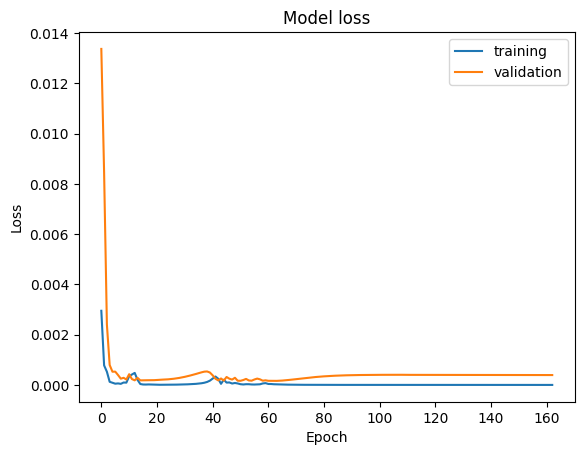

In [29]:
plot_model_training(history_lstm)

29/29 [==============================] - 1s 3ms/step
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_lstm
--------------------------------------------------
look_back days: 30
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 3ms/step
--------------------------------------------------
Train Score: 521.67 RMSE
Test Score: 2747.12 RMSE
--------------------------------------------------
Train Score: 350.60 MAE
Test Score: 2115.61 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)          

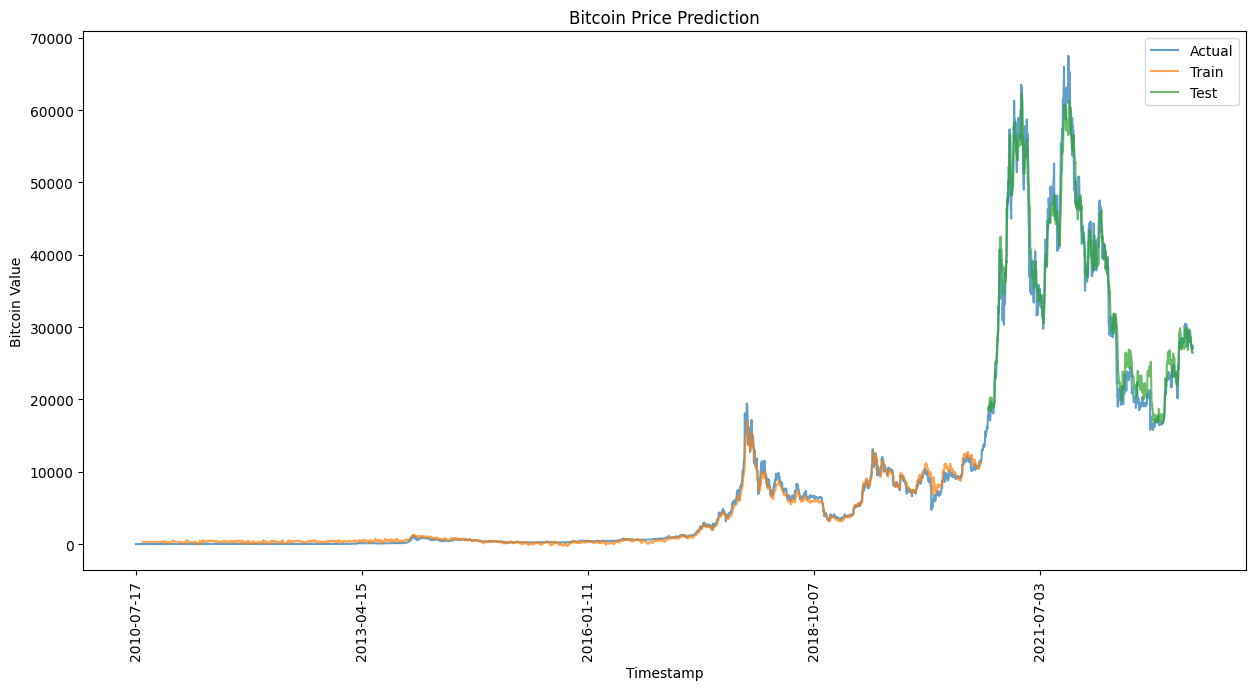

In [30]:
plot_price_prediction(model_lstm)
print_results(model_lstm)

## CNN

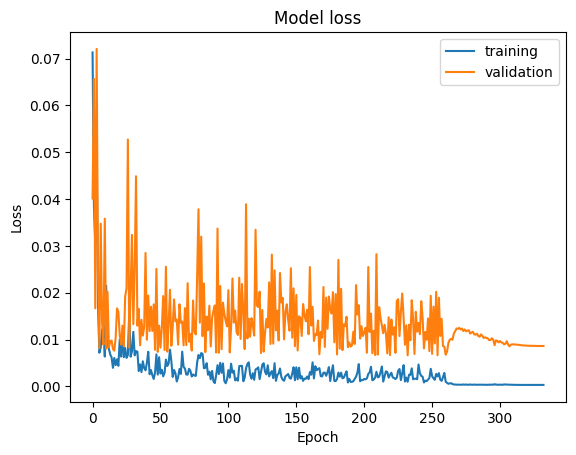

In [31]:
plot_model_training(history_cnn)

29/29 [==============================] - 1s 4ms/step
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_conv1d
--------------------------------------------------
look_back days: 30
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 3ms/step
--------------------------------------------------
Train Score: 579.86 RMSE
Test Score: 4615.64 RMSE
--------------------------------------------------
Train Score: 478.38 MAE
Test Score: 3043.33 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)      

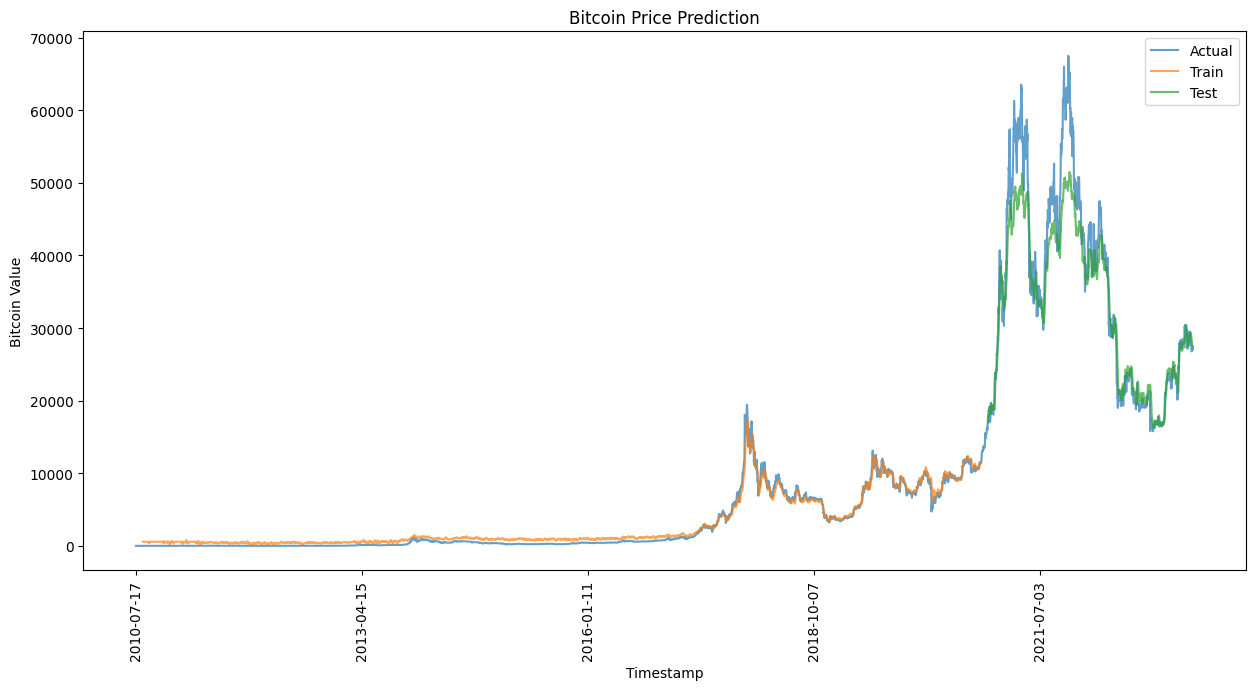

In [32]:
plot_price_prediction(model_cnn)
print_results(model_cnn)

## Ensemble Model

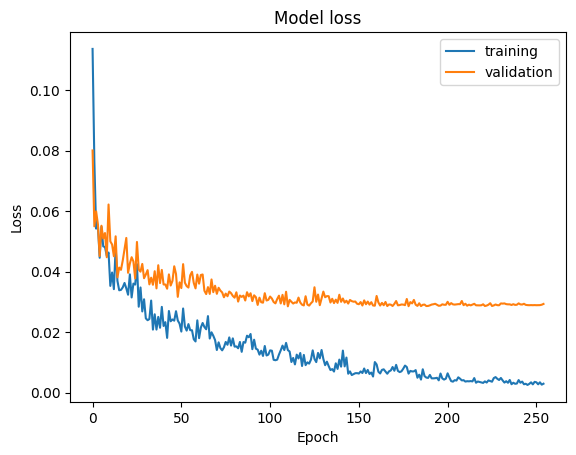

In [33]:
plot_model_training_ensemble(history_ensemble)

29/29 [==============================] - 0s 3ms/step
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_ensemble
--------------------------------------------------
look_back days: 30
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 3ms/step
--------------------------------------------------
Train Score: 1651.03 RMSE
Test Score: 16073.91 RMSE
--------------------------------------------------
Train Score: 1288.23 MAE
Test Score: 13221.24 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)  

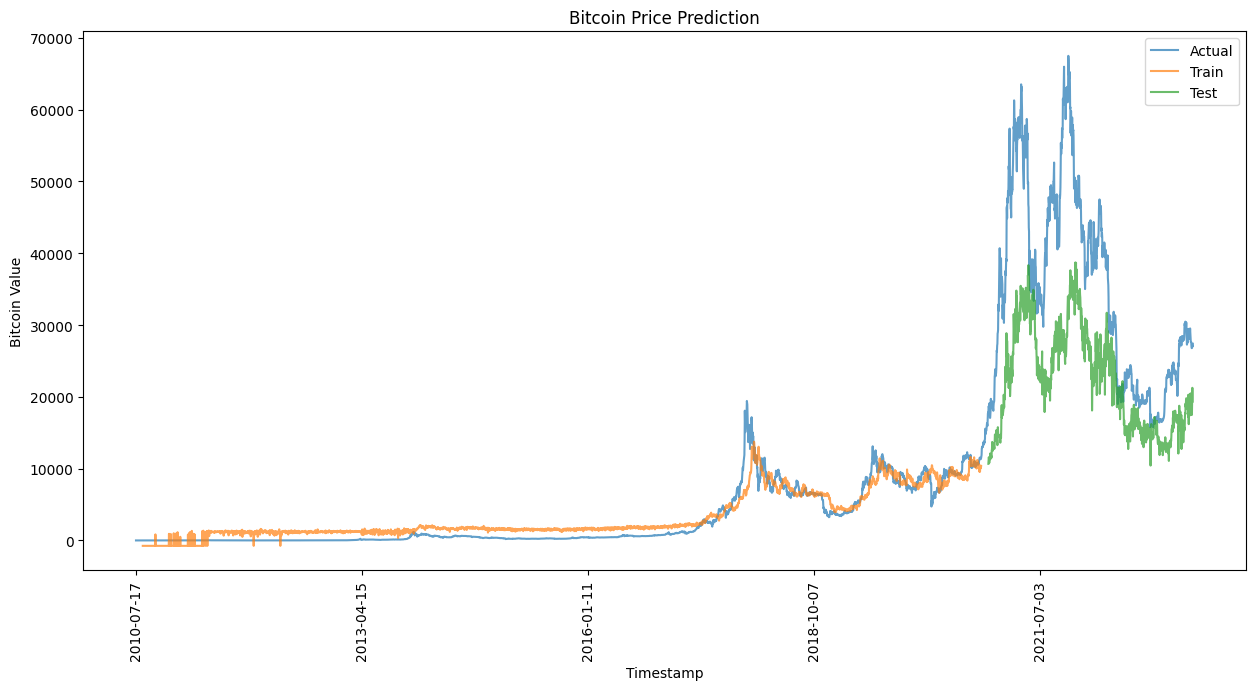

In [34]:
plot_price_prediction_ensemble(ensemble_models)
print_results_ensemble(ensemble_models)